# Setups, Installations and Imports

In [1]:
# !pip install wandb -q
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

PYTHONPATH: c:\Users\abhis\.vscode\extensions\ms-toolsai.jupyter-2021.10.1101450599\pythonFiles;c:\Users\abhis\.vscode\extensions\ms-toolsai.jupyter-2021.10.1101450599\pythonFiles\lib\python
PATH: C:\Users\abhis\mambaforge\envs\tflow;C:\Users\abhis\mambaforge\envs\tflow\Library\mingw-w64\bin;C:\Users\abhis\mambaforge\envs\tflow\Library\usr\bin;C:\Users\abhis\mambaforge\envs\tflow\Library\bin;C:\Users\abhis\mambaforge\envs\tflow\Scripts;C:\Users\abhis\mambaforge\envs\tflow\bin;C:\Users\abhis\mambaforge\condabin;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\dotnet;C:\Program Files\Docker\Docker\resources\bin;C:\ProgramData\DockerDesktop\version-bin;C:\Users\abhis\scoop\apps\gsudo\current;C:\Users\abhis\mambaforge;C:\Users\abhis\mambaforge\Library\mingw-w64\bin;C:\Users\abhis\mambaforge\Library\usr\bin;C:\Users\abhis\mambaforge\Library\bin;C:\Users\abhis\mambaforge\Scripts;C:\Users\abhis\scoo

In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.7.0
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lunchb0ne (use `wandb login --relogin` to force relogin)


True

In [4]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

# Prepare Dataset

In [5]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Visualization of Cifar 10

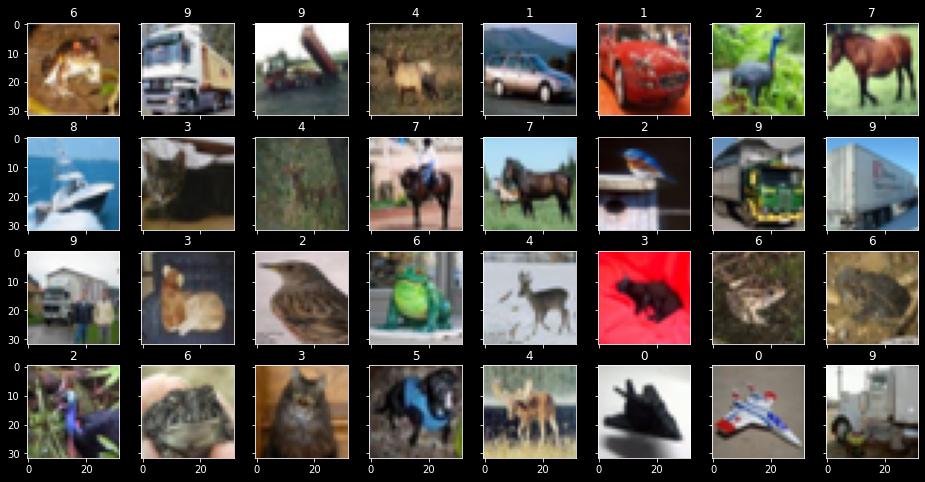

In [6]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [7]:
from utils.createAugment import createAugment

#### Data Generator with Patch Augmentation

In [8]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

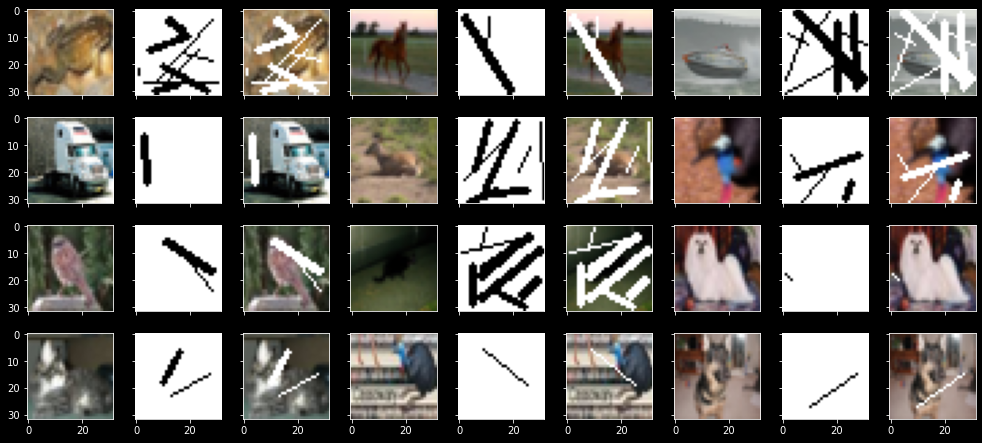

In [9]:
# Legend: Original Image | Mask generated | Masked Image

## Examples
sample_idx = 90 ## Change this to see different batches

[masked_images, masks], sample_labels = traingen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Partial Convolution Based Autoencoder-Decoder Model

In [10]:
## utils is present in the cloned repo. Visit repo for the implementation of PConv2D.
from utils.pconv_layer import PConv2D

In [11]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [12]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

In [13]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (PConv2D)                [(None, 32, 32, 32)  1760        ['input_1[0][0]',                
                                , (None, 32, 32, 32               'encoder_input[0][0]']          
                                )]                                                                
                                                                                              

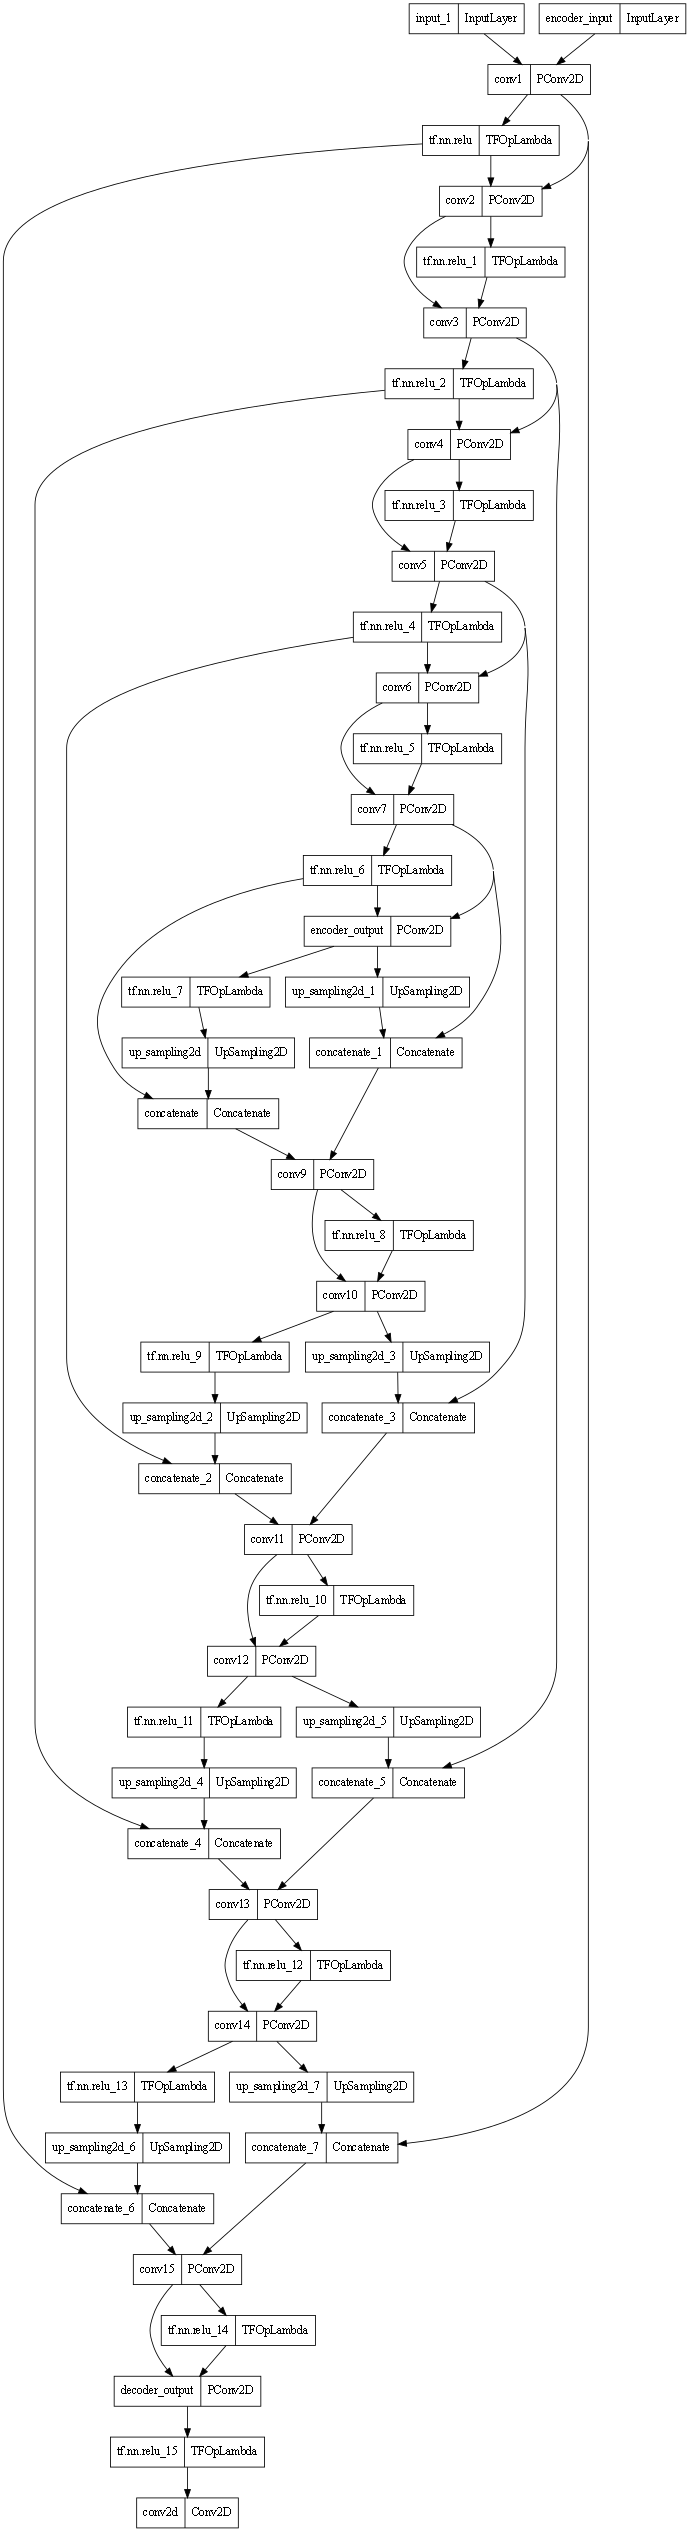

In [14]:
keras.utils.plot_model(model, show_shapes=False, dpi=60, to_file='model_v2.png')

# Train

In [15]:
wandb.init(project="BTP", entity="lunchb0ne")

C:\Users\abhis\mambaforge\envs\tflow\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [16]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  
        
        m_images = []
        binary_masks = []
        predictions = []
        labels = []
        
        for i in range(32):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

        wandb.log({"masked_images": [wandb.Image(m_image)
                              for m_image in m_images]})
        wandb.log({"masks": [wandb.Image(mask)
                              for mask in binary_masks]})
        wandb.log({"predictions": [wandb.Image(inpainted_image)
                              for inpainted_image in predictions]})
        wandb.log({"labels": [wandb.Image(label)
                              for label in labels]})

In [17]:
_ = model.fit(traingen,
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          callbacks=[WandbCallback(),
                     PredictionLogger()])

Epoch 1/20
1562/1562 [==============================] - 75s 41ms/step - loss: 0.0997 - dice_coef: 0.5499 - val_loss: 0.0644 - val_dice_coef: 0.5921
Epoch 2/20
1562/1562 [==============================] - 64s 41ms/step - loss: 0.0611 - dice_coef: 0.5899 - val_loss: 0.0589 - val_dice_coef: 0.5934
Epoch 3/20
1562/1562 [==============================] - 63s 41ms/step - loss: 0.0578 - dice_coef: 0.5912 - val_loss: 0.0569 - val_dice_coef: 0.5924
Epoch 4/20
1562/1562 [==============================] - 63s 40ms/step - loss: 0.0563 - dice_coef: 0.5916 - val_loss: 0.0552 - val_dice_coef: 0.5920
Epoch 5/20
1562/1562 [==============================] - 66s 42ms/step - loss: 0.0426 - dice_coef: 0.5958 - val_loss: 0.0367 - val_dice_coef: 0.6021
Epoch 6/20
1562/1562 [==============================] - 64s 41ms/step - loss: 0.0349 - dice_coef: 0.5981 - val_loss: 0.0337 - val_dice_coef: 0.5994
Epoch 7/20
1562/1562 [==============================] - 64s 41ms/step - loss: 0.0331 - dice_coef: 0.5986 - val_l

# Testing on images

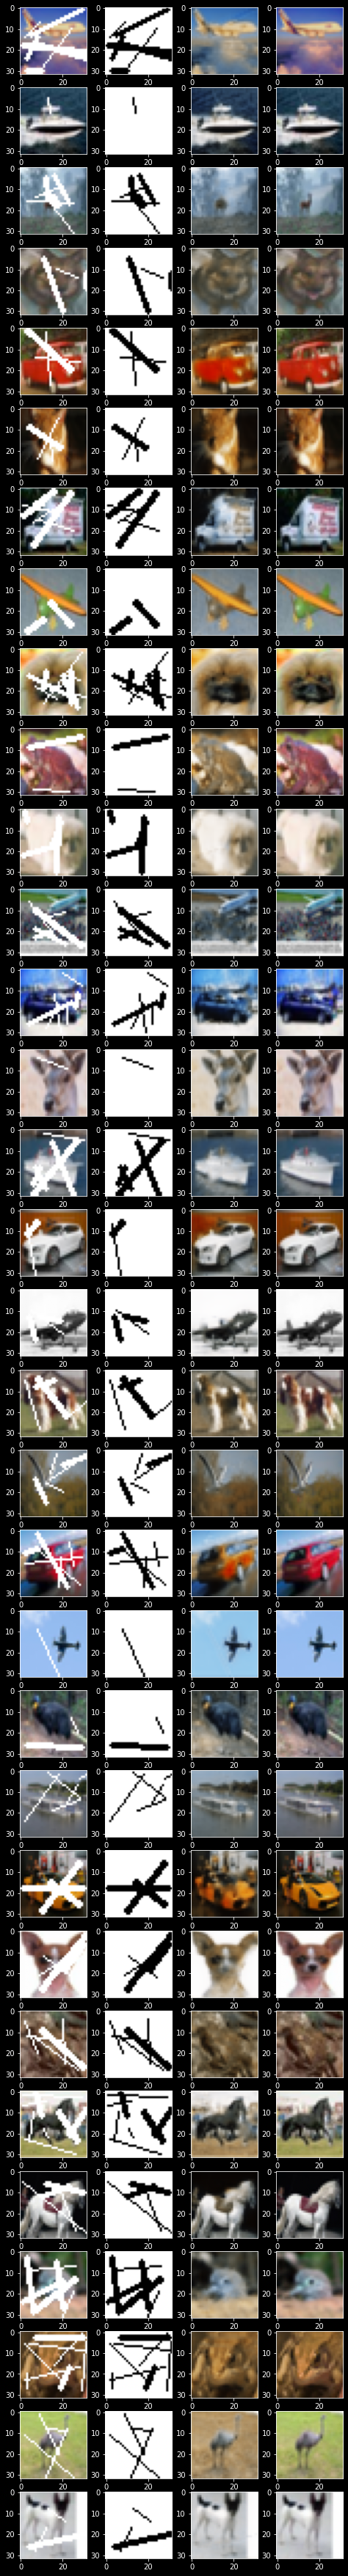

In [18]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth

## Examples
rows = 32
sample_idx = 54
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)
  axs[i][0].imshow(masked_images[i])
  axs[i][1].imshow(masks[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(sample_labels[i])
  
plt.show()